In [12]:
from opt_einsum import contract
import torch
torch.set_default_tensor_type(torch.cuda.DoubleTensor)
device=torch.device('cuda:0')
torch.cuda.set_device(device)
import numpy as np
from ScalingDimensions import get_scaling_dimensions
from HOTRGZ2 import forward_observable_tensors
from TNModels import Ising2D
from tqdm.auto import tqdm
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.colors import hsv_to_rgb

In [13]:
filename1='./data/hotrg_gilt_X24.pth'
filename2='./data/hotrg_gilt_X24_lTRG_gilt_L20.pth'

# filename1='./data/hotrg_X24.pth'
# filename2='./data/hotrg_X24_lTRG_L20.pth'

In [14]:
print('loading coarse-grained tensors...')

options,params,layers,Ts,logTotals=torch.load(filename1,map_location=device)
T0_op,checkerboard=Ising2D(params).get_observables()['magnetization']

def forward_sigmas(positions):
    T_op=forward_observable_tensors(Ts[0],[T0_op]*len(positions),positions,layers[:20],checkerboard=checkerboard,cached_Ts=Ts,user_tqdm=False)[1]
    #T_op=T_op/T_op.norm()
    return T_op

print('done')


loading coarse-grained tensors...
done


In [15]:
print('loading lTRG eigenvectors...')

options1,s_ltrg,u_ltrg=torch.load(filename2,map_location=device)
# if not torch.isclose(u_ltrg[:,:12].imag,torch.tensor(0.)).all():
#     print('Warning: u_ltrg[:,:12] is not real',torch.max(u_ltrg[:,:12].imag).cpu().item())
# u_ltrg=u_ltrg.real
#u_ltrg_backup=u_ltrg.clone()
# for i in range(0,u_ltrg.shape[1]):
#     for j in range(0,i):
#         u_ltrg[:,i]=u_ltrg[:,i]-u_ltrg[:,j]@u_ltrg[:,i]*u_ltrg[:,j]
#     u_ltrg[:,i]=u_ltrg[:,i]/u_ltrg[:,i].norm()
#assert torch.isclose(u_ltrg[:,:12],u_ltrg_backup[:,:12]).all()

scd_ltrg=get_scaling_dimensions(s_ltrg.abs(),scaling=2)
scd_ltrg=[f'{x:.3f}' for x in scd_ltrg]
print(scd_ltrg[:64])
print(s_ltrg.angle())

u_ltrg_inv=torch.linalg.pinv(u_ltrg).T.conj()

# orthogonalize u_ltrg
u_ltrg_orth=u_ltrg.clone()
for i in range(0,u_ltrg.shape[1]):
    for j in range(0,i):
        u_ltrg_orth[:,i]=u_ltrg_orth[:,i]-u_ltrg_orth[:,j]@u_ltrg_orth[:,i]*u_ltrg_orth[:,j]

u_ltrg_useit_dualbasis=u_ltrg_inv
u_ltrg_useit_basis=u_ltrg

loading lTRG eigenvectors...
['0.000', '0.127', '1.003', '1.127', '1.145', '1.999', '2.000', '2.004', '2.043', '2.121', '2.198', '2.205', '2.501', '2.680', '2.688', '2.791', '2.825', '2.825', '2.847', '2.847', '3.012', '3.095', '3.103', '3.103', '3.116', '3.116', '3.159', '3.159', '3.201', '3.204', '3.204', '3.226']
tensor([ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0136, -0.0136,  0.0000,  0.0000, -0.0565,  0.0565,
         0.1737, -0.1737,  0.0228, -0.0228,  0.0000, -0.0387,  0.0387,  3.1416])


In [16]:
def project_out(T,Ys):
    for Y in Ys:
        T=T-contract('ijkl,ijkl->',T,Y)*Y/contract('ijkl,ijkl->',Y,Y)
    return T/T.norm()

def show_overlap_ltrg(v_op,title='',ax=None,k=32):
    if ax is None:
        plt.figure(figsize=(6,2))
    else:
        plt.sca(ax)
    plt.title(title)
    v_op=v_op.flatten().to(torch.complex128)
    #overlap=u_ltrg_inv.T.conj()@v_op
    #overlap=u_ltrg.T.conj()@v_op
    overlap=u_ltrg_useit_dualbasis.T.conj()@v_op
    barHeight=overlap.abs().cpu().numpy()
    barAngle=np.angle(overlap.cpu().numpy())
    barSign=np.sign(overlap.real.cpu().numpy())
    plt.bar(range(k),barHeight[:k],color=.7*plt.cm.hsv(barAngle[:k]/(2*np.pi)))
    plt.xticks(range(k),scd_ltrg[:k],rotation=75)
    plt.axhline(0,color='k')

In [17]:
def get_NPT_operators():
    scan=[511-400,511-200,512+200,512+400]
    scan1=[100,200,400]
    id=forward_sigmas([])
    sig,sigsig,sigsigsig=0,0,0
    for x in scan:
        for y in scan:
            sig+=forward_sigmas([(x,y)])
    for x in scan:
        for dx in scan1:
            L,R=511-dx,512+dx
            ML,MR=511-dx//2,512+dx//2
            sigsig+=forward_sigmas([(x,L),(x,R)])
            sigsig+=forward_sigmas([(L,x),(R,x)])
            for M in [511,512]:
                sigsigsig+=forward_sigmas([(x,ML),(x,M),(x,MR)])
                sigsigsig+=forward_sigmas([(ML,x),(M,x),(MR,x)])
    rtval={'id':id,'sig':sig,'sigsig':sigsig,'sigsigsig':sigsigsig}
    for k in rtval:
        rtval[k]=rtval[k]/rtval[k].norm()
    return rtval

NPT_operators=get_NPT_operators()

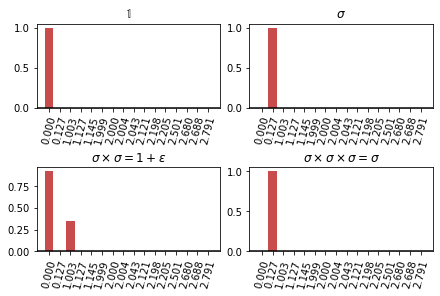

In [18]:
def show_NPT_projections(NPT_operators):

    # sig=forward_sigmas([(M,M)])
    # sigsig=forward_sigmas([(M,L),(M,R)])
    # sigsigsig=forward_sigmas([(M,L),(M,M),(M,R)])

    fig, axes = plt.subplots(2,2, constrained_layout=True,figsize=(6,4))
    show_overlap_ltrg(NPT_operators['id'],title=r'$\mathbb{1}$',ax=axes[0,0],k=16)
    show_overlap_ltrg(NPT_operators['sig'],title=r'$\sigma$',ax=axes[0,1],k=16)
    show_overlap_ltrg(NPT_operators['sigsig'],title=r'$\sigma\times\sigma=1+\epsilon$',ax=axes[1,0],k=16)
    show_overlap_ltrg(NPT_operators['sigsigsig'],title=r'$\sigma\times\sigma\times\sigma=\sigma$',ax=axes[1,1],k=16)
    plt.show()
show_NPT_projections(NPT_operators)

In [19]:
# define the lattice operators
op_latex={
    'id':r'$\mathbb{1}$',
    'sig':r'$\sigma$',
    'eps':r'$\epsilon$',
    'dx_sig':r'$\partial_x\sigma$',
    'dy_sig':r'$\partial_y\sigma$',
    'dx_eps':r'$\partial_x\epsilon$',
    'dy_eps':r'$\partial_y\epsilon$',
    'Tplus':r'$T_+$',
    'Tcross':r'$T_{\times}$',
    'dxx_sig':r'$\partial_{x}^2\sigma$',
    'dyy_sig':r'$\partial_{y}^2\sigma$',
    'dxy_sig':r'$\partial_{x}\partial_{y}\sigma$',
}
def get_lattice_operators():
    scan=[511-200,511-100,512+100,512+200]
    scan1=[50,100,200]
    id=project_out(forward_sigmas([]),[])
    sig=0
    for x in scan:
        for y in scan:
            sig+=project_out(forward_sigmas([(x,y)]),[id])
    id=id/id.norm()
    sig=sig/sig.norm()
    eps,dx_sig,dy_sig,dxx_sig,dyy_sig=0,0,0,0,0
    for x in scan:
        for dx in scan1:
            L,R=511-dx,512+dx
            ML,MR=511-dx+dx//5,512+dx-dx//5
            eps+=project_out(forward_sigmas([(x,L),(x,R)]),[id])
            eps+=project_out(forward_sigmas([(L,x),(R,x)]),[id])
            dx_sig+=project_out(forward_sigmas([(R,x)])-forward_sigmas([(L,x)]),[sig])
            dy_sig+=project_out(forward_sigmas([(x,R)])-forward_sigmas([(x,L)]),[sig])
            dxx_sig+=project_out(forward_sigmas([(R,x)])-forward_sigmas([(MR,x)])-forward_sigmas([(ML,x)])+forward_sigmas([(L,x)]),[sig])
            dyy_sig+=project_out(forward_sigmas([(x,R)])-forward_sigmas([(x,MR)])-forward_sigmas([(x,ML)])+forward_sigmas([(x,L)]),[sig])
    eps=eps/eps.norm()
    Tplus,Tcross,dx_eps,dy_eps,dxy_sig=0,0,0,0,0
    for dx in scan1:
        L,R=511-dx,512+dx
        Tcross+=project_out(forward_sigmas([(R,R),(L,L)])-forward_sigmas([(L,R),(R,L)]),[id,eps])
        dx_eps+=project_out(forward_sigmas([(R,L),(R,R)])-forward_sigmas([(L,L),(L,R)]),[id])
        dy_eps+=project_out(forward_sigmas([(L,R),(R,R)])-forward_sigmas([(L,L),(R,L)]),[id])
        dxy_sig+=project_out(forward_sigmas([(R,R)])-forward_sigmas([(R,L)])-forward_sigmas([(L,R)])+forward_sigmas([(L,L)]),[sig])
        for M in [511,512]:
            Tplus+=project_out(forward_sigmas([(R,M),(L,M)])-forward_sigmas([(M,L),(M,R)]),[id,eps])
        
    rtval={'id':id,'sig':sig,'eps':eps,'dx_sig':dx_sig,'dy_sig':dy_sig,'dx_eps':dx_eps,'dy_eps':dy_eps,'Tplus':Tplus,'Tcross':Tcross,'dxx_sig':dxx_sig,'dyy_sig':dyy_sig,'dxy_sig':dxy_sig}
    for op in rtval:
        rtval[op]=rtval[op]/rtval[op].norm()
    return rtval
lattice_operators=get_lattice_operators()



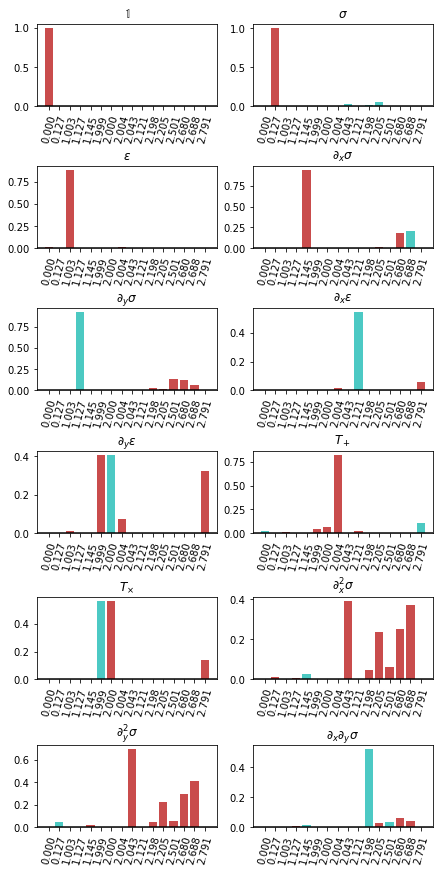

In [20]:
def show_lattice_operator_projections():
    fig, axes = plt.subplots(6,2, constrained_layout=True,figsize=(6,12))
    for i,op in enumerate(lattice_operators):
        show_overlap_ltrg(lattice_operators[op],title=op_latex[op],ax=axes[i//2,i%2],k=16)
    plt.show()
show_lattice_operator_projections()

ul.shape torch.Size([331776, 12])
u_ltrg_inv.shape torch.Size([331776, 32])


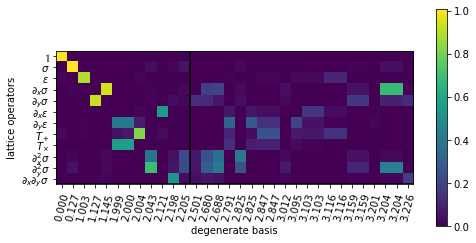

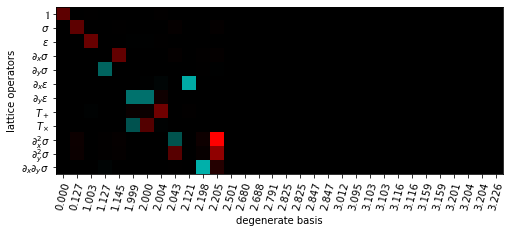

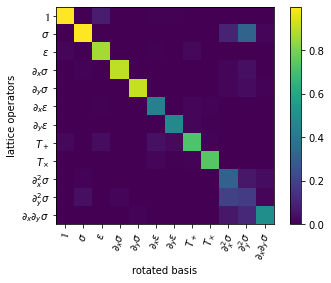

In [21]:
# rotate the degenerate basis to the basis of the lattice operators

def imshow_complex(arr,log=False):
    amp=np.log(np.abs(arr)) if log else np.abs(arr)
    amp=amp/amp.flatten().max()
    color=plt.cm.hsv(np.angle(arr)/(2*np.pi))*np.stack([amp,amp,amp,np.ones_like(amp)],axis=-1)
    plt.imshow(color)

def get_ltrg_operators(lattice_operators):
    ul=torch.stack([(T/T.norm()).flatten() for T in lattice_operators.values()]).T.to(torch.complex128)
    print("ul.shape",ul.shape)
    print("u_ltrg_inv.shape",u_ltrg_inv.shape)
    gram=ul.T.conj()@u_ltrg_useit_dualbasis

    
    #rg1,rg2=[0,1,2,3,5,32],[0,1,2,3,5,12]
    #rg1,rg2=[0,1,2,3,5,9,12],[0,1,2,3,5,9,12]
    rg1,rg2=[0,12],[0,12]
    
    plt.figure(figsize=(8,4))
    plt.imshow(gram.abs().cpu().numpy())
    for i in range(len(rg1)-1):
        plt.axvline(rg1[i+1]-0.5,color='k')
        plt.axhline(rg2[i+1]-0.5,color='k')
    plt.colorbar()
    labels=[op_latex[k] for k in lattice_operators.keys()]
    plt.yticks(range(gram.shape[0]),labels)
    plt.xticks(range(gram.shape[1]),scd_ltrg[:gram.shape[1]],rotation=75)
    plt.ylabel('lattice operators')
    plt.xlabel('degenerate basis')
    plt.show()

    rot=torch.zeros(gram.shape[1],gram.shape[0],dtype=torch.complex128)
    for i in range(len(rg1)-1):
        rot[rg2[i]:rg2[i+1],rg1[i]:rg1[i+1]]=torch.linalg.pinv(gram[rg1[i]:rg1[i+1],rg2[i]:rg2[i+1]])
    
    plt.figure(figsize=(8,4))
    imshow_complex(rot.T.cpu().numpy())
    #plt.imshow(rot.T.abs().cpu().numpy())
    #plt.colorbar()
    plt.yticks(range(gram.shape[0]),labels)
    plt.xticks(range(gram.shape[1]),scd_ltrg[:gram.shape[1]],rotation=75)
    plt.ylabel('lattice operators')
    plt.xlabel('degenerate basis')
    plt.show()

    ur1=u_ltrg_useit_basis@rot

    for i in range(ur1.shape[1]):
        ur1[:,i]=ur1[:,i]/ur1[:,i].norm()

    plt.imshow((ul.T.conj()@ur1).abs().cpu().numpy())
    plt.colorbar()
    plt.yticks(range(gram.shape[0]),labels)
    plt.xticks(range(gram.shape[0]),labels,rotation=75)
    plt.ylabel('lattice operators')
    plt.xlabel('rotated basis')
    plt.show()


    return {k:(ur1[:,i]).reshape(24,24,24,24) for i,k in enumerate(lattice_operators.keys())}

ltrg_operators=get_ltrg_operators(lattice_operators)

In [22]:

data=[]
for x in tqdm(np.linspace(0,1023,111)):
    for y in [511,512]:
        xint,yint=int(x),int(y)
        T_op=forward_sigmas([(xint,yint)])
        T_op=T_op/T_op.norm()
        row={'x':xint,'y':yint}
        for key,op in ltrg_operators.items():
            overlap=op.flatten().conj()@T_op.flatten().to(torch.complex128)
            overlap=overlap.abs()*overlap.real.sign()
            row[key]=overlap.detach().cpu().item()
        data.append(row)


  0%|          | 0/111 [00:00<?, ?it/s]

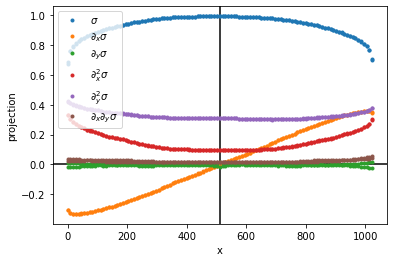

In [23]:
curve=pd.DataFrame(data)

fittings={}
for i,key in enumerate(ltrg_operators.keys()):
    p=np.polyfit(curve['x'].values,curve[key].values,2)
    fittings[key]=p

plt.figure(figsize=(6,4))

plt.axhline(0,color='k')
plt.axvline(511.5,color='k')

for i,key in enumerate(ltrg_operators.keys()):
    normalized=curve[key]/curve['sig']
    normalized=curve[key]
    if(normalized.abs().max()>.01):
        # if key in fittings.keys():
        #     plt.plot(curve['x'],np.polyval(fittings[key],curve['x']),'-',color=plt.cm.rainbow(i/len(ltrg_operators)))
        
        plt.plot(curve['x'],curve[key],'.',label=op_latex[key])



plt.legend()
plt.xlabel('x')
plt.ylabel('projection')
#plt.title(r'projection of $\sigma(x)$ onto lattice operators')
plt.show()

In [24]:
T=Ts[20]
M=contract('iIab,jJba->ijIJ',T,T).reshape(24**2,24**2)
s_cyl,u_cyl=torch.linalg.eig(M)# M=u*s@u.t().conj()
assert torch.isclose(M.cdouble()@u_cyl,u_cyl*s_cyl).all()
assert torch.isclose(u_cyl[:,:32].imag,torch.tensor(0.)).all()
assert torch.isclose(s_cyl.imag,torch.tensor(0.)).all()
u_cyl=u_cyl.real
s_cyl=s_cyl.real.abs()

scd_cyl=get_scaling_dimensions(s_cyl,scaling=np.exp(2*np.pi/2))
scd_cyl=[f'{x:.3f}' for x in scd_cyl]
print(scd_cyl[:64])

['0.000', '0.126', '1.009', '1.136', '1.136', '2.032', '2.029', '2.037', '2.029', '2.154', '2.176', '2.183', '3.008', '3.046', '3.104', '3.102', '3.120', '3.128', '3.175', '3.204', '3.203', '3.230', '3.287', '3.332', '3.518', '3.511', '3.676', '3.699', '3.816', '3.916', '3.949', '4.043', '3.993', '4.003', '4.100', '4.120', '4.149', '4.173', '4.176', '4.205', '4.246', '4.346', '4.247', '4.330', '4.305', '4.328', '4.354', '4.354', '4.535', '4.552', '4.422', '4.416', '4.456', '4.427', '4.443', '4.509', '4.470', '4.468', '4.546', '4.606', '4.579', '4.592', '4.727', '4.717']


In [25]:
def apply_to_state_cyl(T1,T2,v):
    v_op=contract('iIab,jJba,IJ->ij',T1,T2,v.reshape(24,24)).flatten()
    v_op=v_op/v_op.norm()
    return v_op

def apply_to_vacuum_cyl(T1,T2):
    return apply_to_state_cyl(T1,T2,u_cyl[:,0])

data=[]
for x in tqdm(np.linspace(0,1,41)):
    intx=int(x*(2**11-1))
    T_op=forward_sigmas([(0,intx%2**10)])
    if intx>=2**10:
        v_op=apply_to_vacuum_cyl(T,T_op)
    else:
        v_op=apply_to_vacuum_cyl(T_op,T)
    overlap=torch.real(u_cyl.T.conj()@v_op)
    #overlap=overlap/overlap.norm()
    data.append({'x':x,'overlap':overlap.cpu().numpy()})

  0%|          | 0/41 [00:00<?, ?it/s]

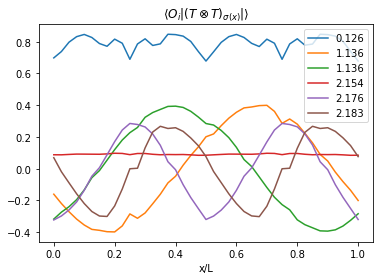

In [26]:
curve=pd.DataFrame(data)
overlaps=np.array(curve['overlap'].tolist())

for i in range(16):
    overlap=overlaps[:,i]#/overlaps[:,1]
    if np.linalg.norm(overlap)>1e-6:
        plt.plot(curve['x'],overlap,label=scd_cyl[i])
plt.legend()
plt.title(r'$\langle{O_i}|(T\otimes T)_{\sigma(x)}|\rangle$')
plt.xlabel('x/L')
plt.show()

In [27]:
def show_overlap_cyl(v_op):
    plt.figure(figsize=(6,2))
    overlap=torch.real(u_cyl.T.conj()@v_op)
    plt.bar(range(32),(overlap[:32]).cpu().numpy())
    plt.xticks(range(32),scd_cyl[:32],rotation=75)


T,T_op,logTotal=forward_observable_tensors(Ts[0],[T0_op],[(2**9-1,0)],layers[:20],checkerboard=checkerboard,cached_Ts=Ts)
show_overlap_cyl(apply_to_vacuum_cyl(ltrg_operators['id'],T));plt.title('id,T|0>')
show_overlap_cyl(apply_to_vacuum_cyl(ltrg_operators['eps'],T));plt.title('eps,T|0>')
show_overlap_cyl(apply_to_vacuum_cyl(ltrg_operators['sig'],T));plt.title('sig,T|0>')
show_overlap_cyl(apply_to_vacuum_cyl(ltrg_operators['dx_sig'],T));plt.title('dx_sig,T|0>')
show_overlap_cyl(apply_to_vacuum_cyl(ltrg_operators['dxx_sig'],T));plt.title('dxx_sig,T|0>')


  0%|          | 0/20 [00:00<?, ?it/s]

RuntimeError: expected scalar type Double but found ComplexDouble

In [ ]:
def fake_T_op(x):
    T_op=0
    for key in fittings.keys():
        T_op+=np.polyval(fittings[key],x)*ltrg_operators[key]
    return T_op

In [ ]:
data_ref=[]
for x in tqdm(np.linspace(0,1,41)):
    intx=int(x*(2**11-1))
    T_op=forward_sigmas([(0,intx%2**10)])
    if intx>=2**10:
        v_op=apply_to_vacuum_cyl(T,T_op)
    else:
        v_op=apply_to_vacuum_cyl(T_op,T)
    overlap=u_cyl.T.conj()@v_op
    data_ref.append({'x':x,
                 'overlap':overlap.cpu().numpy()
                 })

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

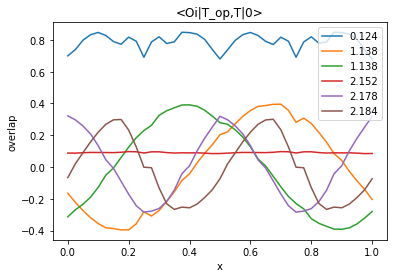

Text(0.5, 1.0, '<Oi|T_op_fake,T|0>')

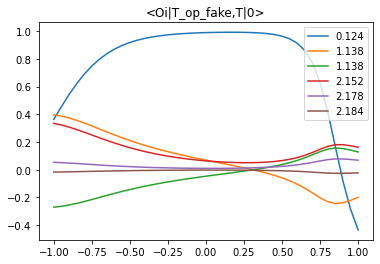

In [ ]:
data_fake=[]
for x in tqdm(np.linspace(-1,1,41)):
    T_op_fake=fake_T_op(x)
    v_op_fake=apply_to_vacuum_cyl(T,T_op_fake)
    overlap_fake=u_cyl.T.conj()@v_op_fake
    data_fake.append({'x':x,
                 'overlap_fake':overlap_fake.cpu().numpy()
                 })

curve_fake=pd.DataFrame(data_fake)
curve_ref=pd.DataFrame(data_ref)
overlaps=np.array(curve_ref['overlap'].tolist())
overlaps_fake=np.array(curve_fake['overlap_fake'].tolist())

for i in range(16):
    overlap=overlaps[:,i]#/overlaps[:,1]
    if np.linalg.norm(overlap)>1e-6:
        plt.plot(curve_ref['x'],overlap,label=scd_cyl[i])
plt.legend()
plt.title('<Oi|T_op,T|0>')
plt.xlabel('x')
plt.ylabel('overlap')
plt.show()

for i in range(16):
    overlap=overlaps_fake[:,i]#/overlaps_fake[:,1]
    if np.linalg.norm(overlap)>1e-6:
        plt.plot(curve_fake['x'],overlap,label=scd_cyl[i])
plt.legend()
plt.title('<Oi|T_op_fake,T|0>')

In [ ]:
# define the lattice operators
op_latex={
    'id':r'$\mathbb{1}$',
    'sig':r'$\sigma$',
    'eps':r'$\epsilon$',
    'dx_sig':r'$\partial_x\sigma$',
    'dy_sig':r'$\partial_y\sigma$',
    'dx_eps':r'$\partial_x\epsilon$',
    'dy_eps':r'$\partial_y\epsilon$',
    'Tplus':r'$T_+$',
    'Tcross':r'$T_{\times}$',
    'dxx_sig':r'$\partial_{x}^2\sigma$',
    'dyy_sig':r'$\partial_{y}^2\sigma$',
    'dxy_sig':r'$\partial_{x}\partial_{y}\sigma$',
}
def get_lattice_operators():
    scan=[511-200,511-100,512+100,512+200]
    scan1=[50,100,200]
    id=project_out(forward_sigmas([]),[])
    sig=0
    for x in scan:
        for y in scan:
            sig+=project_out(forward_sigmas([(x,y)]),[id])
    id=id/id.norm()
    sig=sig/sig.norm()
    eps,dx_sig,dy_sig,dxx_sig,dyy_sig=0,0,0,0,0
    for x in scan:
        for y in scan:
            for dx in scan1:
                L,R=y-dx,y+dx
                ML,MR=y-dx+dx//5,y+dx-dx//5
                eps+=project_out(forward_sigmas([(L,x),(R,x)]),[id])
                eps+=project_out(forward_sigmas([(x,L),(x,R)]),[id])
                dx_sig+=project_out(forward_sigmas([(R,x)])-forward_sigmas([(L,x)]),[sig])
                dy_sig+=project_out(forward_sigmas([(x,R)])-forward_sigmas([(x,L)]),[sig])
                dxx_sig+=project_out(forward_sigmas([(R,x)])-forward_sigmas([(MR,x)])-forward_sigmas([(ML,x)])+forward_sigmas([(L,x)]),[sig])
                dyy_sig+=project_out(forward_sigmas([(x,R)])-forward_sigmas([(x,MR)])-forward_sigmas([(x,ML)])+forward_sigmas([(x,L)]),[sig])
    eps=eps/eps.norm()
    Tplus,Tcross,dx_eps,dy_eps,dxy_sig=0,0,0,0,0
    for x in scan:
        for y in scan:
            for dx in scan1:
                Lx,Rx=x-dx,x+dx
                Ly,Ry=y-dx,y+dx
                Mx,My=x,y
                Tcross+=project_out(forward_sigmas([(Rx,Ry),(Lx,Ly)])-forward_sigmas([(Lx,Ry),(Rx,Ly)]),[id,eps])
                dx_eps+=project_out(forward_sigmas([(Rx,Ly),(Rx,Ry)])-forward_sigmas([(Lx,Ly),(Lx,Ry)]),[id])
                dy_eps+=project_out(forward_sigmas([(Lx,Ry),(Rx,Ry)])-forward_sigmas([(Lx,Ly),(Rx,Ly)]),[id])
                dxy_sig+=project_out(forward_sigmas([(Rx,Ry)])-forward_sigmas([(Rx,Ly)])-forward_sigmas([(Lx,Ry)])+forward_sigmas([(Lx,Ly)]),[sig])
                Tplus+=project_out(forward_sigmas([(Rx,My),(Lx,My)])-forward_sigmas([(Mx,Ly),(Mx,Ry)]),[id,eps])
                
    rtval={'id':id,'sig':sig,'eps':eps,'dx_sig':dx_sig,'dy_sig':dy_sig,'dx_eps':dx_eps,'dy_eps':dy_eps,'Tplus':Tplus,'Tcross':Tcross,'dxx_sig':dxx_sig,'dyy_sig':dyy_sig,'dxy_sig':dxy_sig}
    for op in rtval:
        rtval[op]=rtval[op]/rtval[op].norm()
    return rtval
lattice_operators=get_lattice_operators()

